In [ ]:
##Get data
!git clone https://github.com/franck-dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [ ]:
#Start our experiments using the 20k dataset with numbers replaced w the @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
#Check all the file names in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

#Preprocess data... 
* writing function to read in all of the lines of a target text file



In [ ]:
def get_lines(filename):
  """
  reads text filename and returns the lines of text as a list

  Args: 
    filename: a string contaning the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f: #open this file and save it as f
    return f.readlines()


In [ ]:
# Lets read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines withing the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

How our data will be best respresented:

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated...'
   'total_lines': 11},
   ...]
```

In [ ]:
# Lets write a function which turns each of our datasets into the above format so we
#   can continue to prepare our data for modelling

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract data

  Takes in a filename , reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how manu sentences are in the current abstract, and what sentence number the target
  line is
  """
  input_lines = get_lines(filename) #get all lines from filename 
  abstract_lines = "" #Create empty abstract
  abstract_samples = [] #Create an empty list of abstracts
  
  #Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): #Check to see if line is an ID line, going to return true or false
      abstract_id = line
      abstract_lines = "" #  reset the abstract string if the line is an ID line
    elif line.isspace(): #Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() #Split abstract into seperate lines

      #Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #Create an empty dictionary for each line
        target_text_split= abstract_line.split("\t") #Split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #Get target text and lower it
        line_data["line_number"] = abstract_line_number # What number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) -1 # how many total lines are there in the target abstract
        abstract_samples.append(line_data) #add line data to abstract samples list

    else: # if the above conditions arent fufilled, the line contained a labeled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
#Get data from file and process it 
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") #dev = validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 915 ms, sys: 130 ms, total: 1.05 s
Wall time: 1.21 s


In [ ]:
#Check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

not that our data is in the form of a list of dictionaries, how about we turn it into a dataframe ti further visualize is

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#Distrubution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

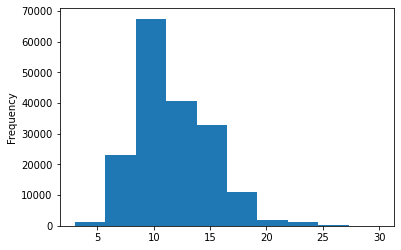

In [ ]:
#Lets check the length of different lines
train_df.total_lines.plot.hist()

###Get lists of sentences


In [ ]:
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_samples), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
#View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

###Make numeric labels(ML models require numeric labels)

In [ ]:
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder #could use tf.onehot
one_hot_encoder = OneHotEncoder(sparse = False) #We want a non sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

#Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

#Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## starting a series of modelling experiments

baseline model: TF-IDF Multinomial Naive Bayes classifier


## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer #This will turn text into numbers
from sklearn.naive_bayes import MultinomialNB #model the numbers
from sklearn.pipeline import Pipeline #or within a pipeline

#Create a pipeline
model_0 = Pipeline([
                   ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

#fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate baseline model on validation dataset
model_0.score(X = val_sentences, #in sklearn its score
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
 #Make predictions using our baseling model
 baseline_preds = model_0.predict(val_sentences)
 baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
### Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-12-17 14:18:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-17 14:18:58 (40.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
#Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

##prepare our data for deep sequence models
before we start building deep models wrve got to create veactorication anf embrddong layers


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

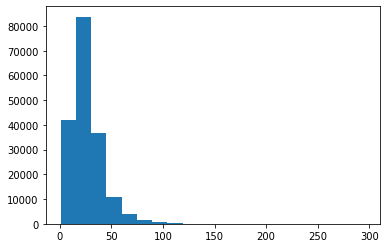

In [ ]:
#Whats the distribution look like 
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20); #Most sentence lengths are under 50

In [ ]:
#How long of a sentence length covers 95% of all examples
output_seq_length = int(np.percentile(sent_lens, 95))
output_seq_length

55

In [ ]:
#Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers


In [ ]:
#How many words are in our vocabulary
max_tokens = 68000


In [ ]:
#Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens, #Numbers of words in vocabulary
                                    output_sequence_length = output_seq_length) #Desired output length of vectorized sequences
                                    

In [ ]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vecotrizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the purpose of this study was to evaluate a personalized protocol with diluted contrast material ( cm ) for coronary computed tomography angiography ( cta ) .

Length of text: 158

Vectorized text: [[   2  695    4   23   17   10    6  164    8 3354  402    7 7096  780
  1904  520   11  346 1490 1236 1579 3605    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
#How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in our vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in our vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in our vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in our vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
#Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding


In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), #Length of our vocabulary
                               output_dim = 128, #different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero = True, #use masking to handle variable sequence lengths(save space)
                               name = "token_embedding")

In [ ]:
#Show example embedding
print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence aftwe vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"sentence after embedding:\n {embedded_sentence}\n")
print(f"Embbeded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 the purpose of this study was to evaluate a personalized protocol with diluted contrast material ( cm ) for coronary computed tomography angiography ( cta ) .

Sentence aftwe vectorization (before embedding):
 [[   2  695    4   23   17   10    6  164    8 3354  402    7 7096  780
  1904  520   11  346 1490 1236 1579 3605    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

sentence after embedding:
 [[[ 0.04372908 -0.03023214 -0.02792214 ...  0.04297607  0.01075709
   -0.01909485]
  [ 0.04273372  0.01024906 -0.03462224 ... -0.00103469  0.04225889
    0.01432384]
  [ 0.0137812  -0.0397067  -0.02902918 ...  0.034222   -0.03165146
   -0.00922311]
  ...
  [ 0.0209471  -0.0497097   0.01961401 ...  0.02403169  0.01282586
   -0.04297664]
  [ 0.0209471  -0.0497097   0.01961401 ...  0.02403169  0.01282586
   -0.04297664]
  [ 0.0209471  -0.04970

## Creating datasets (making sure our data loads as fast as possible)

In [ ]:
#Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
#Take the tensor slice datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model_1: Conv11D with token embeddings 

In [ ]:
#Create Convd1D model to process sequences
inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text input to integers
token_embeddings = token_embed(text_vectors) # Create embedding
x = layers.Conv1D(64, kernel_size=5, padding = "same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

#Compile
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
#Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))) #Only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 17s 13ms/step - loss: 0.9159 - accuracy: 0.6403 - val_loss: 0.6805 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6569 - accuracy: 0.7583 - val_loss: 0.6272 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6187 - accuracy: 0.7745 - val_loss: 0.5963 - val_accuracy: 0.7856


In [ ]:
#Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5993 - accuracy: 0.7861


[0.5992825031280518, 0.7861445546150208]

In [ ]:
#Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs


array([[3.7385964e-01, 2.0951872e-01, 1.2309557e-01, 2.6003796e-01,
        3.3488151e-02],
       [4.7259432e-01, 2.2679049e-01, 1.4949964e-02, 2.7815816e-01,
        7.5070979e-03],
       [1.2757562e-01, 6.6804546e-03, 2.1061760e-03, 8.6357164e-01,
        6.6130044e-05],
       ...,
       [2.0881434e-06, 6.9731724e-04, 5.2998360e-04, 2.0974521e-06,
        9.9876851e-01],
       [4.6528585e-02, 4.6569428e-01, 1.1542271e-01, 6.4855307e-02,
        3.0749911e-01],
       [1.8729810e-01, 6.8901318e-01, 3.3150770e-02, 3.0016920e-02,
        6.0520966e-02]], dtype=float32)

In [ ]:
#Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
#Calculate model 1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.6144578313253,
 'f1': 0.7837669615914755,
 'precision': 0.7829495222797721,
 'recall': 0.786144578313253}

## Model_2: Feature extraction with pretrained token embeddings

lets use pretrained word embeddings more specifically the universal sentence encoder


In [ ]:
#Download pretrained TF Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [ ]:
#Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding: \n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence: 
 to address the public health crisis of overweight and obese preschool-age children , the nutrition and physical activity self assessment for child care ( nap sacc ) intervention was delivered by nurse child care health consultants with the objective of improving child care provider and parent nutrition and physical activity knowledge , center-level nutrition and physical activity policies and practices , and children 's body mass index ( bmi ) .
sentence after embedding: 
 [ 0.00104253  0.0430507   0.02124167 -0.00640587 -0.06742665  0.0156818
  0.02103657  0.05194415  0.03733629  0.00371092  0.06783765  0.0379498
 -0.00251937 -0.05671672 -0.06830198 -0.04370384 -0.06935965  0.05903261
 -0.06692582 -0.06569531  0.06781469 -0.05537152  0.03667058 -0.05690121
  0.02957515 -0.02617772 -0.04274704  0.0349705   0.05397696 -0.06135435]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings tensorflow hub 

In [ ]:
#Define feature extraction model using tf hub layer
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation = "softmax")(x) #Create the output layer
model_2 = tf.keras.Model(inputs= inputs,
                         outputs = outputs,
                         name = "model_2_feature_extractor")
#Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [ ]:
model_2.summary()

Model: "model_2_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model 2 to the data 
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int( 0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9206 - accuracy: 0.6480 - val_loss: 0.7959 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7677 - accuracy: 0.7017 - val_loss: 0.7522 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7503 - accuracy: 0.7127 - val_loss: 0.7341 - val_accuracy: 0.7148


In [ ]:
#Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7378 - accuracy: 0.7151


[0.7377901077270508, 0.7151132225990295]

In [ ]:
#Make prediction with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3251002e-01, 3.4875613e-01, 2.1375655e-03, 2.0985398e-01,
        6.7423428e-03],
       [3.5643035e-01, 4.9125370e-01, 2.9287527e-03, 1.4668940e-01,
        2.6977228e-03],
       [2.3579994e-01, 1.2972872e-01, 2.0827068e-02, 5.7737982e-01,
        3.6264505e-02],
       ...,
       [1.7880951e-03, 5.8575757e-03, 6.5207839e-02, 8.5233030e-04,
        9.2629415e-01],
       [4.0016361e-03, 4.8280802e-02, 1.8129857e-01, 1.4917171e-03,
        7.6492727e-01],
       [1.8637969e-01, 3.1459397e-01, 4.3397859e-01, 9.0821804e-03,
        5.5965651e-02]], dtype=float32)

In [ ]:
#Convert the prediction probabilities found with the feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#Calculate results from TF hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.51132000529591,
 'f1': 0.7122524827747815,
 'precision': 0.7151475848026003,
 'recall': 0.7151132000529591}

##Conv1D with character embeddings 



###Creating character-level tokenizer

In [ ]:
#Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

#Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

"t o   a d d r e s s   t h e   p u b l i c   h e a l t h   c r i s i s   o f   o v e r w e i g h t   a n d   o b e s e   p r e s c h o o l - a g e   c h i l d r e n   ,   t h e   n u t r i t i o n   a n d   p h y s i c a l   a c t i v i t y   s e l f   a s s e s s m e n t   f o r   c h i l d   c a r e   (   n a p   s a c c   )   i n t e r v e n t i o n   w a s   d e l i v e r e d   b y   n u r s e   c h i l d   c a r e   h e a l t h   c o n s u l t a n t s   w i t h   t h e   o b j e c t i v e   o f   i m p r o v i n g   c h i l d   c a r e   p r o v i d e r   a n d   p a r e n t   n u t r i t i o n   a n d   p h y s i c a l   a c t i v i t y   k n o w l e d g e   ,   c e n t e r - l e v e l   n u t r i t i o n   a n d   p h y s i c a l   a c t i v i t y   p o l i c i e s   a n d   p r a c t i c e s   ,   a n d   c h i l d r e n   ' s   b o d y   m a s s   i n d e x   (   b m i   )   ."

In [ ]:
#split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#Whats the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

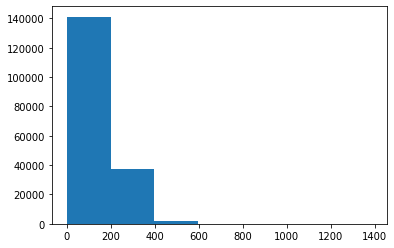

In [ ]:
#Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7);


In [ ]:
#Find what character length convers 95% of sequnces
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
#Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #Add two for spacebar and OOV token(out of vocab)
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    #Set standatdization to none if you want to leave punctuation in
                                    name = "char_vectorizer")

In [ ]:
#Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)


In [ ]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"NUmber of different characteres in charachter vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

NUmber of different characteres in charachter vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
#Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   i n t e r v e n t i o n   i n c l u d e s   f o u r   c o m p o n e n t s   :   t h e   p r o v i s i o n   o f   k i t s   w i t h   a l l   n e c e s s a r y   m e d i c i n e s   a n d   l a b o r a t o r y   s u p p l i e s   f o r   a n c   (   m e d i c a l   a n d   n o n - m e d i c a l   e q u i p m e n t   )   ,   a   s t o r a g e   s y s t e m   ,   a   t r a c k i n g   s y s t e m   ,   a n d   t r a i n i n g   s e s s i o n s   f o r   h e a l t h   c a r e   p r o v i d e r s   .
Length of random_train_chars: 214
Vectorized chars:
 [[ 3 13  2  4  6  3  2  8 21  2  6  3  4  7  6  4  6 11 12 16 10  2  9 17
   7 16  8 11  7 15 14  7  6  2  6  3  9  3 13  2 14  8  7 21  4  9  4  7
   6  7 17 23  4  3  9 20  4  3 13  5 12 12  6  2 11  2  9  9  5  8 19 15
   2 10  4 11  4  6  2  9  5  6 10 12  5 22  7  8  5  3  7  8 19  9 16 14
  14 12  4  2  9 17  7  8  5  6 11 15  2 10  4 11  5 12  5  6 10  6  7  6
  15  2 10  4 11  5 12  2 26 16  4 14 15  2  6  3 

## Creating character-level embedding

In [ ]:
#Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), #number of different characters
                              output_dim = 25, # size of char embedding in papper
                              mask_zero = False,
                              name = "char_embed")


In [ ]:
#Test out character embedding layer
print(f"charified text:\n {random_train_chars} \n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

charified text:
 t h e   i n t e r v e n t i o n   i n c l u d e s   f o u r   c o m p o n e n t s   :   t h e   p r o v i s i o n   o f   k i t s   w i t h   a l l   n e c e s s a r y   m e d i c i n e s   a n d   l a b o r a t o r y   s u p p l i e s   f o r   a n c   (   m e d i c a l   a n d   n o n - m e d i c a l   e q u i p m e n t   )   ,   a   s t o r a g e   s y s t e m   ,   a   t r a c k i n g   s y s t e m   ,   a n d   t r a i n i n g   s e s s i o n s   f o r   h e a l t h   c a r e   p r o v i d e r s   . 

Embedded chars. (after vectorization and embedding):
 [[[ 0.00876311 -0.04582208  0.01462065 ...  0.02394127 -0.008728
   -0.03086177]
  [ 0.04449929  0.01514718 -0.03343673 ...  0.04935373 -0.02391151
   -0.02484575]
  [ 0.00613625 -0.0213306  -0.01891732 ...  0.04805252 -0.02633631
   -0.03196169]
  ...
  [-0.02502622  0.01241239 -0.02140095 ...  0.03170888 -0.02431448
   -0.02262014]
  [-0.02502622  0.01241239 -0.02140095 ...  0.03170888 -0.02431448
   -0.02262014

###Building a Conv1D model to fit on character embeddings 

In [ ]:
#Make Conv1D on chars only

input_layer = layers.Input(shape =(1,), dtype = "string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_3_conv1D_char_embeddings")
#Compile
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
#Summary
model_3.summary()


Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 

In [ ]:
#Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
#Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2710 - accuracy: 0.4855 - val_loss: 1.0524 - val_accuracy: 0.5831
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0090 - accuracy: 0.5965 - val_loss: 0.9346 - val_accuracy: 0.6323
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9220 - accuracy: 0.6397 - val_loss: 0.8567 - val_accuracy: 0.6769


In [ ]:
#Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17209445, 0.38508278, 0.05933063, 0.3530751 , 0.03041692],
       [0.14800183, 0.663655  , 0.00921084, 0.16138063, 0.01775169],
       [0.07754841, 0.41607428, 0.10897426, 0.36111075, 0.03629225],
       ...,
       [0.02351497, 0.03680062, 0.04658316, 0.04420718, 0.84889406],
       [0.02118253, 0.17991121, 0.15481985, 0.02187056, 0.62221587],
       [0.44213238, 0.38542783, 0.08456033, 0.06946671, 0.01841272]],
      dtype=float32)

In [ ]:
#Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [ ]:
#Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 66.1624520058255,
 'f1': 0.6515568569664237,
 'precision': 0.6582047017777545,
 'recall': 0.661624520058255}

##Model:4 Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token level embedding (similar `model_1`)
2 Create a character-level model (similar `model_3`)
3. Combine 1 and 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as inputs and produces sequence label probabilities as output


In [ ]:
#Setup token input/model
token_inputs = layers.Input(shape =[], dtype = tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

#2. setup char inputs/model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output, 
                                                                    char_model.output])
#4. Create ouput layers - adding in dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

#5. Construct model with char and tplen inputs
model_4 = tf.keras.Model(inputs =[token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

In [ ]:
#Get a summary of our model 
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

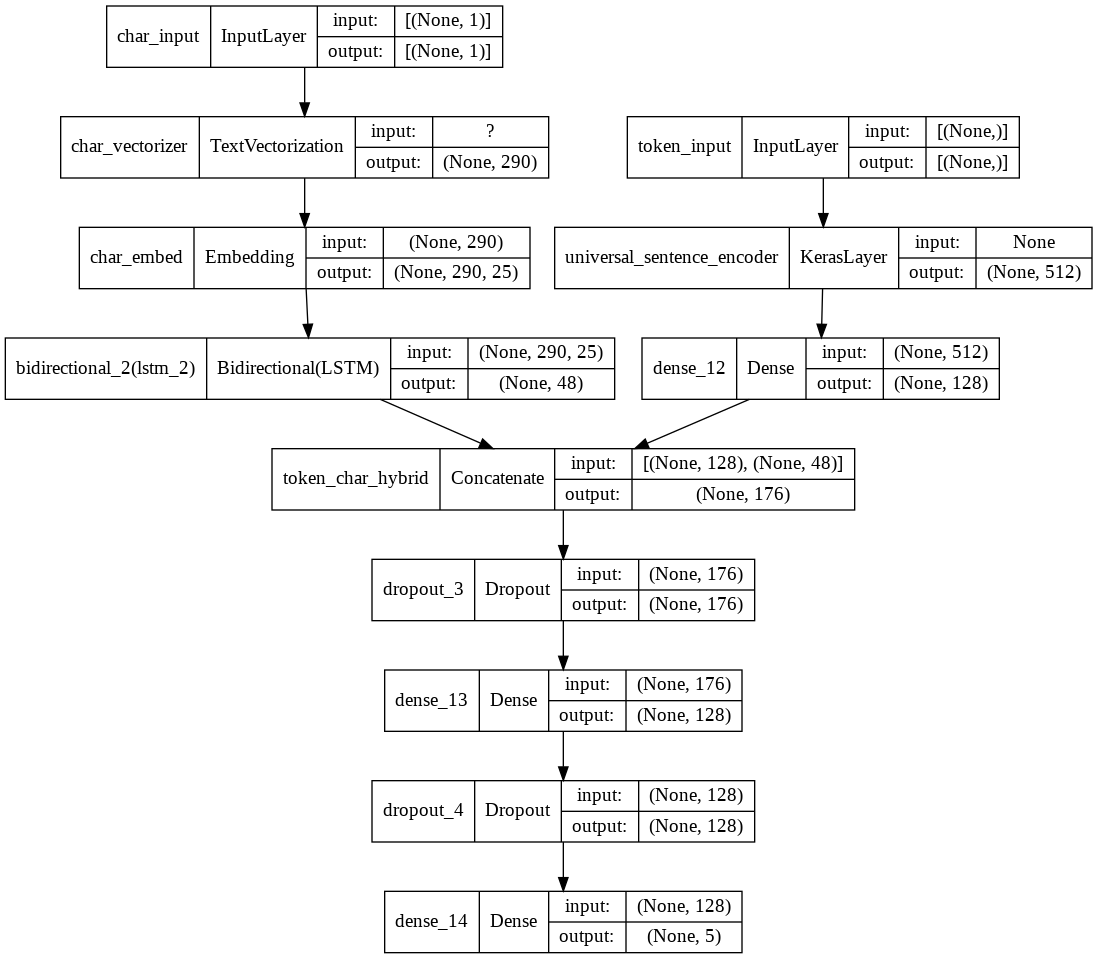

In [ ]:
#Plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
#Compile token char model
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Combining token and character data into a tf.data dataset

In [ ]:
#Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #Combine data and labels

#Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
#Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #Make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #Make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #Combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
#Check out our training and token embedding dataset
train_char_token_dataset, val_char_token_dataset 

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

Fitting a model on token and character level sequences

In [ ]:
#Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 78s 130ms/step - loss: 0.3454 - accuracy: 0.5914 - val_loss: 0.2762 - val_accuracy: 0.6938
Epoch 2/3
562/562 [==============================] - 71s 127ms/step - loss: 0.2811 - accuracy: 0.6872 - val_loss: 0.2546 - val_accuracy: 0.7211
Epoch 3/3
562/562 [==============================] - 71s 126ms/step - loss: 0.2695 - accuracy: 0.7048 - val_loss: 0.2458 - val_accuracy: 0.7330


In [ ]:
#Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 53s 56ms/step - loss: 0.2453 - accuracy: 0.7305


[0.24532252550125122, 0.7305375337600708]

In [ ]:
#Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.43082219e-01, 5.37351370e-01, 1.27939228e-03, 1.11880444e-01,
        6.40654983e-03],
       [3.04991275e-01, 5.49826622e-01, 1.08287297e-03, 1.42546564e-01,
        1.55265140e-03],
       [3.13072175e-01, 1.60476878e-01, 4.06387262e-02, 4.57055241e-01,
        2.87569333e-02],
       ...,
       [5.46240299e-05, 6.16038626e-04, 3.23549658e-03, 1.71042957e-05,
        9.96076763e-01],
       [2.57066987e-03, 2.26337202e-02, 1.07564822e-01, 1.07433239e-03,
        8.66156399e-01],
       [2.20019981e-01, 4.77504551e-01, 2.29794070e-01, 8.13143793e-03,
        6.45499602e-02]], dtype=float32)

In [ ]:
#Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
#Get results of token char hybrid model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.05375347544022,
 'f1': 0.7269790962705824,
 'precision': 0.7331978160985193,
 'recall': 0.7305375347544022}

#Model:5 Transfer learning with pretrained token embeddings + character embeddings + positional embeddings
 

###Create positional embeddings

#How many different line numbers are there (looking at the distribution of total lines)


In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

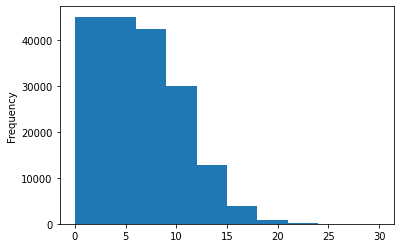

In [ ]:
#Check the distribution of "line_number" cloumn

train_df.line_number.plot.hist()

In [ ]:
#Use tensor flow to create on hot encoded tensors of our line number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
#Theres one of these arrays(one hot encoded array) for every sample in our training data frame


now weve encoded our lines number feature, lets do the same for our total lines feature 

In [ ]:
#How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

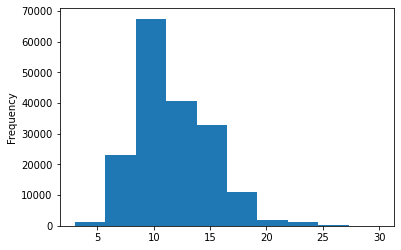

In [ ]:
#Check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
#Check the coverage of a total lines value of 20
np.percentile(train_df.total_lines, 98) #if we chose 20 lines to one-hot-encode it would 98% of samepls

20.0

In [ ]:
#Use tensorflow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)
train_total_lines_one_hot.shape, train_total_lines_one_hot [:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

###Building a tribrid embedding model

1.Create a token level model
2. Create a character level model
3. Create a model for the line_number feature
4. Create a model for the total_lines feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and the outputs of 7 into a tf.keras.model

In [ ]:
#1. Token inputs
from tensorflow.keras import layers

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs =  token_inputs,
                             outputs = token_outputs)
#2. Char inputs
char_inputs = layers.Input(shape = (1, ), dtype="string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

#3. Line numbers model
#inputs, shape = ?
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
#Dense layer with 32 units and relu activation
x = layers.Dense(32, activation = "relu")(line_number_inputs) #Dense layer of 32, each input is going to be embedded into a feature vector of 32
#Combine inputs and dense layer into model
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)
#4. Total lines model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)
#5. Combine token and char embedding into a hybrid embedding
combined_embedding = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output,
                                                                               char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embedding)
z = layers.Dropout(0.5)(z)

#6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                   total_lines_model.output,
                                                                                   z])
#7. Create output layer 
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

#8.put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "model_5_tribrid_embedding_model")


In [ ]:
#Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

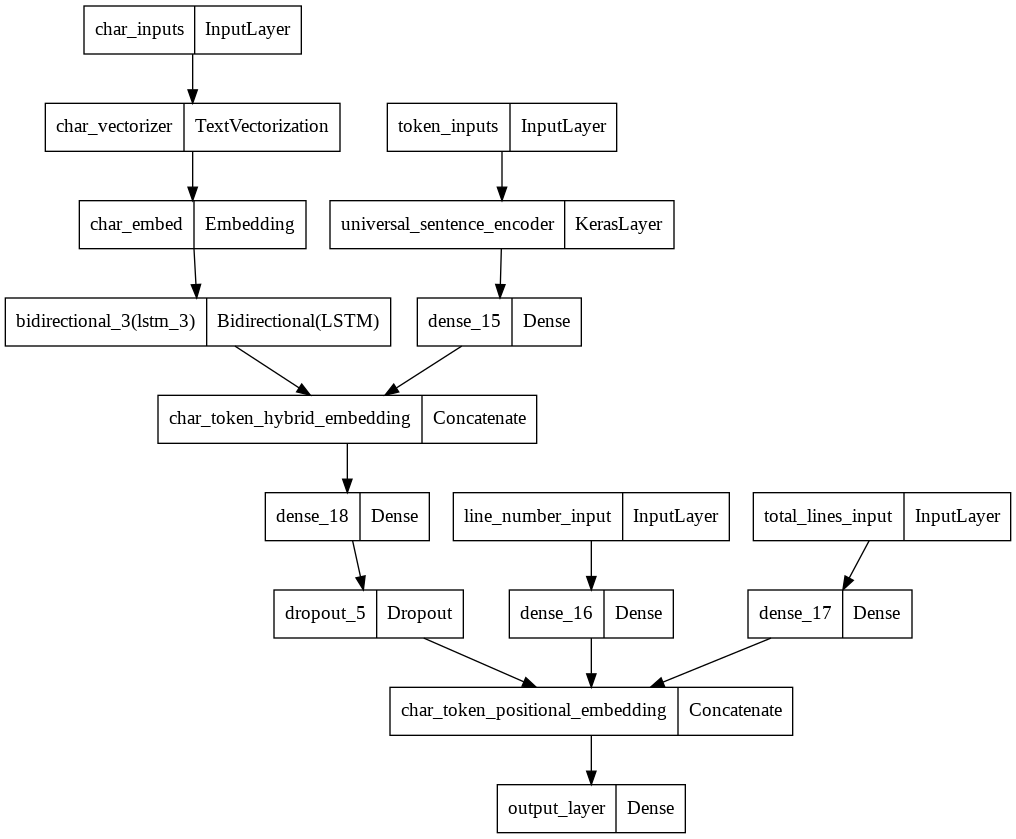

In [ ]:
#plot model_5 and explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
#Compile token, char, and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),#helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

###Create tribrid embeddding datasets using tf.data

In [ ]:
#Create teaining and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#do the same as above for the validation dataset

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
#Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

###Fitting, evaluating, and making predictions with our tribrid model


In [ ]:
#Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 *  len(train_char_token_pos_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 74s 121ms/step - loss: 1.0912 - accuracy: 0.7294 - val_loss: 0.9826 - val_accuracy: 0.8055
Epoch 2/3
562/562 [==============================] - 66s 117ms/step - loss: 0.9672 - accuracy: 0.8162 - val_loss: 0.9493 - val_accuracy: 0.8285
Epoch 3/3
562/562 [==============================] - 66s 118ms/step - loss: 0.9511 - accuracy: 0.8238 - val_loss: 0.9378 - val_accuracy: 0.8301


In [ ]:
#Make some predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 51s 53ms/step


array([[0.49556184, 0.10565947, 0.01081077, 0.36966887, 0.01829905],
       [0.5206286 , 0.09545961, 0.05352947, 0.31807345, 0.01230892],
       [0.28357464, 0.11157207, 0.11634479, 0.43137062, 0.05713788],
       ...,
       [0.03320629, 0.10070756, 0.03999356, 0.02839717, 0.7976954 ],
       [0.03124866, 0.2906848 , 0.08336561, 0.02522325, 0.56947774],
       [0.2870845 , 0.53013   , 0.08466811, 0.04509013, 0.05302721]],
      dtype=float32)

In [ ]:
#Convert pred probs to pred labels 
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
#Calculate results of char token pos model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.24506818482722,
 'f1': 0.8314452915651411,
 'precision': 0.8311591148816769,
 'recall': 0.8324506818482722}

##Compare model results

In [ ]:
#Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding" : model_4_results,
                                  "model_5_pos_char_token_embedding" : model_5_results})
all_model_results = all_model_results.transpose()
all_model_results


,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.614458,0.782950,0.786145,0.783767
model_2_pretrained_token_embedding,71.511320,0.715148,0.715113,0.712252
model_3_custom_char_embedding,66.162452,0.658205,0.661625,0.651557
model_4_hybrid_char_token_embedding,73.053753,0.733198,0.730538,0.726979
model_5_pos_char_token_embedding,83.245068,0.831159,0.832451,0.831445


In [ ]:
#Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

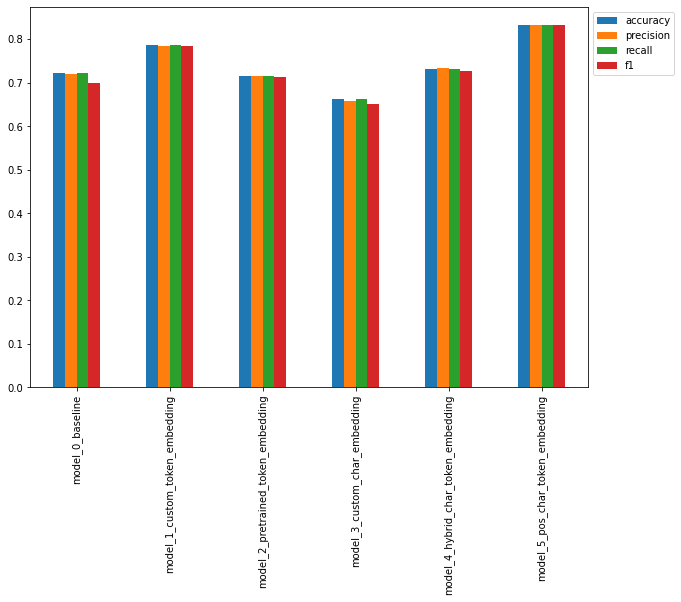

In [ ]:
#Plot and compare all model results
all_model_results.plot(kind = "bar", figsize = (10,7)).legend(bbox_to_anchor=(1.0, 1.0));

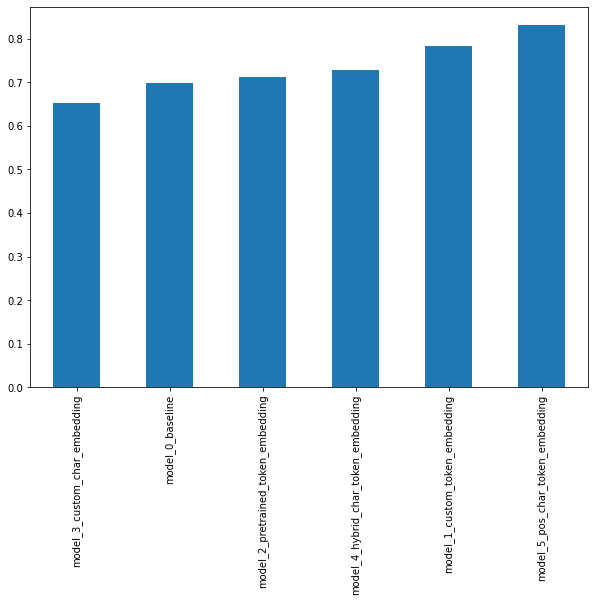

In [ ]:
#Sort models by f1-scores
all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind = "bar", figsize = (10,7))

##Save and load model

In [ ]:
#Save the best performing model to saved model format (default)

model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
#load in best performing model
path = "/content/skimlit_tribrid_model"
loaded_model = tf.keras.models.load_model(path)

In [ ]:
#make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_preds[:10]


In [ ]:
#Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded+preds)
loaded_model_results

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
#Check loaded model summary
loaded_model.summary()